# Homework 2 from Martin Gräf, Richard Baumann and Thomas Block

## Exercise 1

After taking a look at the one-dimensional ising model in Homework 1, we now take a look at the two-dimensional variant. Again we have the hamiltonian:


\begin{equation}
    H(\sigma) = - J \sum_{\langle x~y\rangle} \sigma_x \sigma_y - h \sum_x \sigma_x
\end{equation}





In [17]:
#just importing stuff, nothing to see here yet :)

import numpy as np 
import random as rd
import matplotlib.pyplot as plt
import math
import itertools 
import scipy.special as sp

This time we not only look at the particles left and right of the observed particle, but at the particles above and below. Therefore the hamiltonian looks like this:

\begin{equation}
    H(\sigma) = - J (\sigma_{x-1, y} \sigma_{x, y} + \sigma_{x+1, y} \sigma_{x1, y} + \sigma_{x, y-1} \sigma_{x, y} + \sigma_{x+1, y} \sigma_{x, y}) - h \sigma_{x, y}
\end{equation}

As we can see in the equation above, this hamiltonian looks at all adjacent spins. Therefore, the implementation looks something like that:


In [18]:
#Spin is supposed to be a NxN big array. Position has to be an array of the form [x, y] to indicate the position of the spin.
def hamiltionian(spin_array, position, j, h):
    minuend=0
    if position[0]+1<len(spin_array[0])-1:
        minuend = minuend + spin_array[position[0]+1][position[1]] * spin_array[position[0]][position[1]]
    else:
        minuend = minuend + spin_array[0][position[1]] * spin_array[position[0]][position[1]]
    if position[1]+1<len(spin_array[0])-1:
        minuend = minuend + spin_array[position[0]][position[1]+1] * spin_array[position[0]][position[1]]
    else:
        minuend = minuend + spin_array[0][position[1]] * spin_array[position[0]][position[1]] 
    return (-j*minuend-h*spin_array[position[0]][position[1]])

Now we have to generate a spin array, that can be used later on. This array has to be two dimensional. This spin-arry is $ N_{x} $ x $ N_{y} $ large, however in accordance to the exercise sheet we choose $ N_{x}=N_{y} $.

In [19]:
def gen_spin_array(length):
    configurations=np.zeros(length*length).reshape(length, length)
    current_configuration=np.zeros(length) 
    for j in range(length):
        for i in range(length):
            #a random integer between 1 and 3 (1, 2)
            current_configuration[i]=(2*rd.randint(1, 2)-3)
        configurations[j]=current_configuration
    return configurations

We can carry over the other instructions from the previous homework. Therefore, we assume, that the spins are distributed following a Bolzmann distribution (a fact, that is given by the exercise sheet):

\begin{equation}
    P(s)=\frac{ exp \big[-\frac{H(s)}{k_{b}T} \big]}{\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]}  = \frac{1}{Z} exp \big[-\frac{H(s)}{k_{b}T} \big].
\end{equation}

Thus, Z can be determined via:

\begin{equation}
    Z={\sum_{s`} exp \big[-\frac{H(s`)}{k_{b}T}\big]} 
\end{equation}

In [20]:
def z_simulated(spin_array, j, h, t):
    sum=0
    for k in range(len(spin_array[0])):
        for l in range(len(spin_array[0])):
            sum=sum+np.exp(-hamiltionian(spin_array, [k, l], j, h)/t)
    return (sum)

And, the magnetization per spin is defined as:

\begin{equation}
    <m>=+\frac{T}{N}\frac{\partial log(Z)}{\partial h} 
\end{equation}

In [21]:
def magnetization_random_configurations(spin_array, j, h, t, intervall):
    z_1=z_simulated(spin_array, j, h+(intervall/2), t)
    z_2=z_simulated(spin_array, j, h-(intervall/2), t)
    return (t/(len(spin_array[0])**2)*((np.log(z_1)-np.log(z_2))/intervall))

TODO: Make the mathematical proves that u need.

However, unlike in the last homework, where we just calculated H to calculate Z in order to compute m, we take a different approach. We try and simplefy the terms that we have untill we get a direct way to compute the magnetization. The magnitization can be expresses as the sum of all spins:

In [22]:
def magnetization_smart(spin_array):
    return (spin_array.sum()/(len(spin_array[0])))

#Todo Format this better with markdown. The desired Format is in Lecture 3 Slide 55

Here comes the part that is different to the last homework. Instead of brute forcing the solution we now have a plan. We will use the Metropolis-Hastings Method:

1. We take a random spin from our matrix
2. Then we flip the spin ($s_{i}=-1*s_{i}$)
3. The change in energy is calculated
4. Actual Metropolis-Hastings step:
    A if $\Delta S < 0 $ ACCEPT the spin flip
    B else sample > ~ U(0,1)
        if y $\leq exp(-\Delta S)$ ACCEPT the spin flip
        otherwise REJECT the spin flip and keep the original spin s_{i}
5. Steps 1-4 are repeated for $\Lambda$ times (which is called sweep)

First we will implement a sweep. One thing to mention is, that sampling over a uniform distribution as written above can slow down the algorihm. Importance sampling is much better for a problem like this.

In [23]:
def sweep(spin_array, j, h, t):
    #Choose a random position
    x=rd.randint(0, len(spin_array[0])-1)
    y=rd.randint(0, len(spin_array[0])-1)
    s_prior=0
    s_later=0
    #If we reach borders, we return on the other side of the Problem.
    i=l=-1
    if x+i==0:
        i=len(spin_array)-2
    if y+l==0:
        l=len(spin_array)-2
    #Calculate Energy prior to flip
    """
    for k in range(len(spin_array[0])):
        for l in range(len(spin_array[0])):
            s_prior=s_prior+hamiltionian(spin_array, [k, l], j, h)/t
    """
    s_prior=hamiltionian(spin_array, [x, y], j, h)/t+hamiltionian(spin_array, [x+i, y], j, h)/t+hamiltionian(spin_array, [x, y+l], j, h)/t
    #hamiltionian(spin_array, [x, y], j, h)/t+hamiltionian(spin_array, [x+i, y], j, h)/t+hamiltionian(spin_array, [x, y+l], j, h)/t 
    #Flip Spin
    spin_array[x, y]=-spin_array[x, y]
    #Calculate Energy after flip
    """
    for k in range(len(spin_array[0])):
        for l in range(len(spin_array[0])):
            s_later=s_later+hamiltionian(spin_array, [k, l], j, h)/t
    """
    s_later=hamiltionian(spin_array, [x, y], j, h)/t+hamiltionian(spin_array, [x+i, y], j, h)/t+hamiltionian(spin_array, [x, y+l], j, h)/t
    #Computing the Energy
    delta_s=s_later-s_prior
    if delta_s>0:
        r=rd.randint(0, 1)
        if r>math.exp(-delta_s):
            spin_array[x, y]=-spin_array[x, y]
    return(spin_array)


Now these sweeps are executed a lot of times. The next steps are:

6. Measure the a relevant property (magnetization, internal energy, etc.)
7. Repeat from step 1 (Over time magnetization should converge towards the real value of the observable)

In [24]:
#lambda seems to cause a invalid syntax error 
def mc_estimate(spin_array, j, h, t, repeats):
    for k in range(repeats):
        m=np.zeros(repeats)
        #normally the number of sweeps could be randomly choosen, but the exercise sheet, as far as I could understand 
        #was insisting, that lambda=N_x+N_y
        for i in range(len(spin_array)*len(spin_array)):
            spin_array=sweep(spin_array, j, h, t)
    #m[k]=magnetization_random_configurations(spin_array, j, h, t, 0.01)
    m[k]=magnetization_smart(spin_array)
    return (np.average(m), spin_array)

## Exercise 2

Todo: How does the numerical cost of the calculation of the energy (for a given spin configuration) scale with the system size $\Lambda$ ? 

## Exercise 3

Todo: Assuming you’ve flipped one spin $s_{i}$, how does the numerical cost of the calculation of the change in energy $\Delta S$ scale with the system size $\Lambda$ ?

## Exercise 4

Todo: What is the significance of the critical coupling $J_c$ ?

## Exercise 5

Now we can look at how the magnetization changes when the relevant parameters change. We choose different N-value and just see how m is dependent on h.

$h \in [-1, 1]$

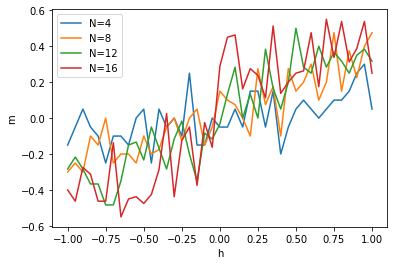

In [25]:
def plot_m_h_dependency(j, t, repeats):
    h_array=np.arange(-1, 1.01, 0.05)
    spin_array_array=[]
    for i in [4, 8, 12, 16, 20]:
        spin_array_array=spin_array_array+[gen_spin_array(i)]
    #print(spin_array_array)
    m_array_4=np.zeros(len(h_array))
    m_array_8=np.zeros(len(h_array))
    m_array_12=np.zeros(len(h_array))
    m_array_16=np.zeros(len(h_array))
    for i in range(len(h_array)):
        m_array_4[i], a=mc_estimate(spin_array_array[0], j, h_array[i], t, repeats)
        m_array_8[i], a=mc_estimate(spin_array_array[1], j, h_array[i], t, repeats)
        m_array_12[i], a=mc_estimate(spin_array_array[2], j, h_array[i], t, repeats)
        m_array_16[i], a=mc_estimate(spin_array_array[3], j, h_array[i], t, repeats)
    plt.plot(h_array, m_array_4, label="N=4")
    plt.plot(h_array, m_array_8, label="N=8")
    plt.plot(h_array, m_array_12, label="N=12")
    plt.plot(h_array, m_array_16, label="N=16")
    plt.legend(loc="best")
    plt.xlabel("h")
    plt.ylabel("m")
    plt.savefig("h_m_dependency.png")

plot_m_h_dependency(0.5, 0.5, 10)

## Exercise 6

It is also interesting to take a look, at the average energy per site. An analytical solution in the thermodynamic limit is given by:
\begin{equation}
    \epsilon=−J \coth (2J) (1 + \frac{2}{\pi} (2 \tanh^2(2J)−1)K(4sech^2(2J) tanh^2(2J)))
\end{equation}

With K beeing the incomplete elliptic integral of the first kind. This can be calculated by using the formula

\begin{equation}
    F(x ; k) = \int_{0}^{x} \frac{\mathrm{d}t}{\sqrt{\left(1 - t^2\right)\left(1 - k^2 t^2\right)}}
\end{equation}

This formula could be implemented by hand, however in the package scipy we have the function scipy.special.ellipkinc, which calculates the incomplete elliptic integral of the first kind. 

The mean energy can be implemented by calculating all energies and calculating the mean of it:



We only look at a certain j intervall: $j \in [0.25, 1]$.

In [26]:
def mean_energy_analytical(j):
    spherical=sp.ellipkinc(math.pi/2, 4*math.cosh(2*j)**-2*math.tanh(2*j)**2)
    return (-j*(math.cosh(2*j)/math.sinh(2*j))*(1+2*math.pi*(2*math.tanh(2*j)**2-1)*spherical))

def mean_energy_simulated(spin_array, N, j, t):
    energy = np.zeros(N*N).reshape(N, N)
    spin_array = gen_spin_array(N)
    for i in range(N):
        for k in range(N):
            energy[i][k] = hamiltionian(spin_array, [i, k], j, 0)
    return(np.average(energy))

0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


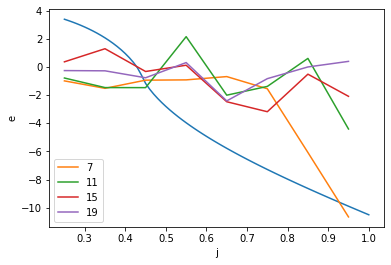

In [30]:
def plot_mean_energy(h, t, repeats, averaging):
    #get the analytical results
    j_array_analytical=np.arange(0.25, 1.01, 0.01)
    mean_energy_array_analytical=np.zeros(len(j_array_analytical))
    for i in range(len(j_array_analytical)):
        mean_energy_array_analytical[i]=mean_energy_analytical(j_array_analytical[i])
    
    #generate simulated results
    #The N-Values that are going to be used
    N_array=[7, 11, 15, 19]
    #We will have all values from 0.25 to 1 in a 0.1 intervall
    j_array_simulated=np.arange(0.25, 1.01, 0.05)
    temp_energy_array=np.zeros(averaging)
    mean_energy_array_simulated=np.zeros(len(j_array_simulated)*4).reshape(4, len(j_array_simulated))
    mean_energy_array_simulated_temp=np.zeros(len(j_array_simulated)*4).reshape(4, len(j_array_simulated))
    spin_array_array=[]

    for d in range(averaging):
        #loop over all possible N values ([7, 11, 15, 19])
        for k in range(len(N_array)):
            #loop over all possible j values
            for i in range(len(j_array_simulated)):
                #Generate Spin arrays
                for o in range(len(N_array)):
                    spin_array_array=spin_array_array+[gen_spin_array(N_array[o])]
                #make monte carlo simulations of the spin arrays
                for m in range(len(N_array)):
                    a, spin_array_array[k]=mc_estimate(spin_array_array[m], j_array_simulated[k], 0, t, repeats)
                #calculate the mean energy
                mean_energy_array_simulated_temp[k][i]=mean_energy_simulated(spin_array_array[k], N_array[k], j_array_simulated[i], t)
        #print(mean_energy_array_simulated)
        mean_energy_array_simulated=mean_energy_array_simulated+mean_energy_array_simulated_temp
    mean_energy_array_simulated=mean_energy_array_simulated/averaging
    plt.plot(j_array_analytical, mean_energy_array_analytical)
    for k in range(len(N_array)):
        plt.plot(j_array_simulated, mean_energy_array_simulated[k]*100, label=N_array[k])
    plt.xlabel("j")
    plt.ylabel("e")
    plt.legend(loc="best")
    plt.savefig("plot_mean_energy.png")

plot_mean_energy(0, 1, 1, 20)

## Exercise 7

We can also calculate an analytical solution for absolute value of the mean magnetization. This is given by:

\begin{equation}
        |m| = \left\{
		\begin{array}{ll}
		\left(\frac{1}{\sinh^4(2J)}\right)^{\frac{1}{8}}, &\text{ if }J_c < J \\
		0 & else 
		\end{array}
		\right.
\end{equation}

We can compare this to our simulated result. For the comparison we only look a certain J interval. 

$j \in [0.25, 1]$

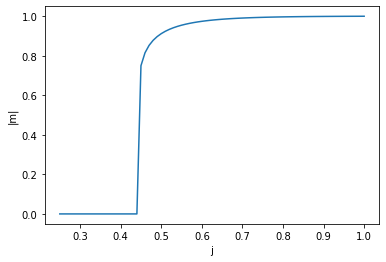

In [28]:
def mean_magnetization_analytical(j):
    if j>0.440686793509772:
        return ((1-(1/(math.sinh(2*j)**4)))**(1/8))
    else:
        return 0

def plot_mean_magnetization(N, h, t, repeats):
    j_array=np.arange(0.25, 1.01, 0.01)
    mean_magnetization_array=np.zeros(len(j_array))
    for i in range(len(j_array)):
        mean_magnetization_array[i]=mean_magnetization_analytical(j_array[i])
    plt.plot(j_array, mean_magnetization_array)
    plt.xlabel("j")
    plt.ylabel("|m|")
    plt.savefig("plot_mean_energy.png")

plot_mean_magnetization(4, 1, 1, 100)